In the previous post, titled [Extract weights from Keras's LSTM and calcualte hidden and cell states](https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html), I discussed LSTM model. In this blog post, I would like to discuss the stateful flag in Keras's recurrent model.

 If you google "stateful LSTM" or "stateful RNN", google shows many blog posts discussing and puzzling about this notorious parameter, e.g.:

- [Don't use stateful LSTM unless you know what it does](https://github.com/keras-team/keras/issues/7212)
- [Simple stateful LSTM example](https://github.com/keras-team/keras/issues/6168)
- [Keras - stateful vs stateless LSTMs](https://stackoverflow.com/questions/39681046/keras-stateful-vs-stateless-lstms)
- [Convert LSTM model from stateless to stateful](https://github.com/keras-team/keras/issues/5714)

I hope to give some understanding of stateful prediction through this blog. 

# Stateful flag is Keras

All the RNN or LSTM models are stateful **in theory**. These models are meant to remember the entire sequence for prediction or classification tasks. However, in practice, you need to create a batch to train a model with backprogation algorithm, and the gradient can't backpropagate between batches. This means that if you have a long time series which does not fit into a single batch, you need to divide the time series into multiple sub-time series and each sub time series goes to separate batch. Then LSTM only remember what happened within a batch. At the initial time point of every batch, states are initialized and set to 0. No previous information. This is very unfortunate because RNN or LSTM are introduced to remember all the past history to predict the next time point. Nope, it only remembers what happened within the batch time series length! 


Stateful flag in Keras is introduced to circumvent these problems during training, and make the model remember what happened in the previous batch by passing states from the previous batch to the next batch. Also, stateful = True makes a lot of sense during the prediction phase because otherwise the RNN trained with batch time series length $T$ assumes that the hidden states are initialized to zero at every $T$ steps. This means that in order to predict the value at time point $t$, we need to feed foward the network assuming that $h_{t-T}=0$ for $T$ times and in order to predict the value at time point $t+1$, we AGAIN need to feed forward the network for $T$ times assuming that $h_{t-T+1}=0$. This point was discussed greatly in my previous blog.

### History of Stateful flag 


#### Training with Stateful = True

Here, I introduce two nice blogs discussing stateful flag.

[**Philippe Remy's blog post**](http://philipperemy.github.io/keras-stateful-lstm/) provided nice introduction to understand the stateful flag of Keras's RNN model. It discusses how to train a model with stateful = True. However, although I like this blog post, it also contributed for the confusion because the example uses 

> batch_input_shape=(1, 1, 1)

which simply does not work for most of the time series examples even when you train a model with stateful = True. This means that your batch only contains a single time point from a single time series. 


[**Jason Brownlee's blog**](https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/) is another great blog post that gives good stateful examples. Jason says:  

"_[Stateful = True] is truly how the LSTM networks are intended to be used. We find that by allowing the network itself to learn the dependencies between the characters, that we need a smaller network (half the number of units) and fewer training epochs (almost half)._"

As he only try fitting stateful LSTM to a small simple example, I cannot generalize his comment, but it is nice to learn that training with stateful=True works for his example.

In this blog post, I would like to also discuss the training with stateful = True.

#### Training with Stateful = False and Prediction with Stateful = True.

The usefulness of stateful method during the prediction is also discussed. There are lots of discussions online that try to use stateful = True only during the prediction phase:

- "_Why anybody would want to have a stateful model during training is beyond me, so this part I can agree with. But during testing, when you want to let the model predict some output on some data, then stateful makes a lot more sense. For example, it might be a part of a larger system that works on video frames. It might be required to perform some action instantly after each frame, instead of waiting for a sufficiently long sequence of video frames before being fed to the network. It would be really nice if you could train the network stateless with a time-depth of X (say 16), and then use those weights on a stateful network with a time-depth of 1 during prediction. In my experience however, this does not work in Keras._" -- [ahrnbom  commented on Sep 19 2017](https://github.com/keras-team/keras/issues/7212) 


- "_The length of my input sequences is variable and has a quite high variance (from very short sequences to nearly 1000 long sequences). At training time I can just divide the sequences in batches of fixed sizes but at test time it would be useful to feed the whole sequence and possibly get prediction at every time step.Is it possible to train the model in stateless mode feeding fixed length sequences and then make predictions in a stateful fashion? Does this even make sense or am I missing something?_"--[fedebecat  commented on Mar 11 2017](https://github.com/keras-team/keras/issues/5714)

I was also fascinated with these ideas. In fact, writing scripts for stateful training is a bit cumbersome because you have to reset sequence by yourself. However, after what I have seen in [my previous post titled Understand Keras's RNN behind the scenes with a sin wave example - Stateful and Stateless prediction -](https://fairyonice.github.io/Understand-Keras's-RNN-behind-the-scenes-with-a-sin-wave-example.html), I am very skeptical about this. Remember, stateful prediction and stateless prediction returns different results when model is trained stateless! And it was such a simple data (sin wave).

Therefore, in this blog post, I will train model in stateful setting and show how the results are different from a model trained in stateless setting.

## Reference in this blog
- [Understand Keras's RNN behind the scenes with a sin wave example - Stateful and Stateless prediction -](https://fairyonice.github.io/Understand-Keras's-RNN-behind-the-scenes-with-a-sin-wave-example.html)
- [Extract weights from Keras's LSTM and calcualte hidden and cell states](https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html)

In [121]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)


python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
keras version 2.1.3
tensorflow version 1.5.0



I will create a synthetic long time series data just as in [Extract weights from Keras's LSTM and calcualte hidden and cell states](https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html). But this time, I will make the data more complex by using much larger $D$. 

## Create synthetic long time series data

I will generate a time series $X_{t}$ ($t=1,...,T$) as my independent feature.
As the target, or dependent time series, I will create a time series $Y_{t}$ as a function of a single time series $\{ X_{k} \}_{k=1}^t$.


Given integers $D$ and $T$, the time series $X_{t}$ an $Y_t$ are generated as:

$$
C \sim \textrm{Multinomial}(5,6,...,99)\\
U \sim \textrm{Unif}([0,1])\\
X_{t} = -\frac{t}{T}U\left[ \textrm{Cos}\left(\frac{t}{1+C}\right) \right]\\
Y_{t} = X_{t-2} X_{t-\textrm{D}} \textrm{ for t > D else } Y_t = 0 
$$

We consider a long time series $T = 1,000$. 

The parameter $D$ determines the time lag. The larger $D$ is, the longer it takes for the $Y_{t}$ to show the effect of $X_{t}$, and the longer memory that the deep learning model needs to remember. For this exercise, I will consider $D=100$, and generate 1,000 sets of time series, independently.

## Generate training data

In [122]:

def random_sample(len_ts=3000,D=1001):
    c_range = range(5,100)
    c1 = np.random.choice(c_range)
    u = np.random.random(1)
    const = -1.0/len_ts
    ts = np.arange(0,len_ts)
    
    x1 = np.cos(ts/float(1.0 + c1))
    x1 = x1*ts*u*const
    
    y1 = np.zeros(len_ts)

    for t in range(D,len_ts):
        ## the output time series depend on input as follows: 
        y1[t] = x1[t-2]*x1[t-D] 
    y = np.array([y1]).T
    X = np.array([x1]).T
    return y, X
def generate_data(D= 1001,Nsequence = 1000,T=4000, seed=123):
    X_train = []
    y_train = []
    set_seed(sd=seed)
    for isequence in range(Nsequence):
        y, X = random_sample(T,D=D)
        X_train.append(X)
        y_train.append(y)
    return np.array(X_train),np.array(y_train)

D = 100 
T = 1000
X, y = generate_data(D=D,T=T,Nsequence = 1000)
print(X.shape, y.shape)

((1000, 1000, 1), (1000, 1000, 1))


## Plot examples of the generated time series
Notice that in every time series, the later 500 seconds are more variable.

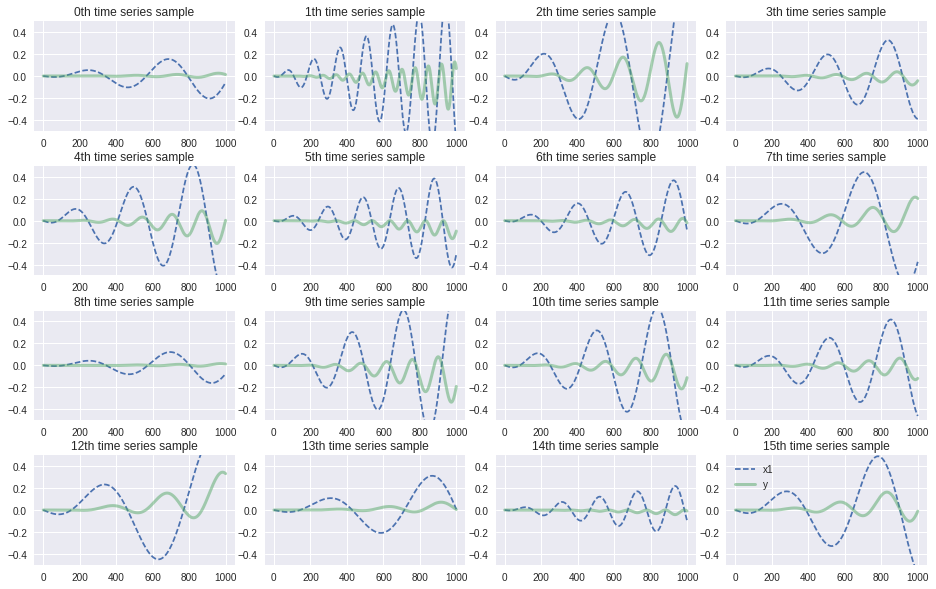

In [160]:
def plot_examples(X,y,ypreds=None,nm_ypreds=None):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace = 0.32,wspace = 0.15)
    count = 1
    n_ts = 16
    for irow in range(n_ts):
        ax = fig.add_subplot(n_ts/4,4,count)
        ax.set_ylim(-0.5,0.5)
        ax.plot(X[irow,:,0],"--",label="x1")
        ax.plot(y[irow,:,:],label="y",linewidth=3,alpha = 0.5)
        ax.set_title("{:}th time series sample".format(irow))
        if ypreds is not None:
            for ypred,nm in zip(ypreds,nm_ypreds):
                ax.plot(ypred[irow,:,:],label=nm)   
        count += 1
    plt.legend()
    plt.show()
    if ypreds is not None:
        for y_pred, nm_ypred in zip(ypreds,nm_ypreds):
            loss = np.mean( (y_pred[:,D:,:].flatten() - y[:,D:,:].flatten())**2)
            print("The final validation loss of {} is {:7.6f}".format(
                nm_ypred,loss))
        
plot_examples(X,y,ypreds=None,nm_ypreds=None)

## Split between training and testing 
Define weights just like  [Extract weights from Keras's LSTM and calcualte hidden and cell states](https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html).

In [124]:
prop_train = 0.8
ntrain = int(X.shape[0]*prop_train)

w = np.zeros(y.shape[:2])
w[:,D:] = 1 
w_train = w

X_train, X_val = X[:ntrain], X[ntrain:]
y_train, y_val = y[:ntrain], y[ntrain:]
w_train, w_val = w[:ntrain], w[ntrain:]

## Define LSTM model (stateful and stateless)
Now I define stateful LSTM model. 

In [125]:
from keras import models, layers

def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(inp,rnn,dens))



## Stateless model as a reference

Define a model.
In the [Extract weights from Keras's LSTM and calcualte hidden and cell states](https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html), the number of hidden units was as less as 3. However, this time, the dependencies between $Y_t$ and $X_t$ are more complex because of the magnitude of $D$. The LSTM model needs to remember longer history of $X_t$.


In [152]:
hunits = 64
model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000, 1)           0         
_________________________________________________________________
RNN (LSTM)                   (None, 1000, 64)          16896     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 1000, 1)           65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Model training

In [153]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=400,
                             epochs=100,
                             verbose=2,
                              sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))

Train on 800 samples, validate on 200 samples
Epoch 1/100
 - 6s - loss: 0.0076 - val_loss: 0.0072
Epoch 2/100
 - 4s - loss: 0.0070 - val_loss: 0.0072
Epoch 3/100
 - 4s - loss: 0.0070 - val_loss: 0.0072
Epoch 4/100
 - 4s - loss: 0.0070 - val_loss: 0.0072
Epoch 5/100
 - 4s - loss: 0.0070 - val_loss: 0.0072
Epoch 6/100
 - 4s - loss: 0.0069 - val_loss: 0.0072
Epoch 7/100
 - 4s - loss: 0.0069 - val_loss: 0.0072
Epoch 8/100
 - 4s - loss: 0.0069 - val_loss: 0.0072
Epoch 9/100
 - 4s - loss: 0.0070 - val_loss: 0.0072
Epoch 10/100
 - 3s - loss: 0.0070 - val_loss: 0.0071
Epoch 11/100
 - 4s - loss: 0.0069 - val_loss: 0.0071
Epoch 12/100
 - 4s - loss: 0.0069 - val_loss: 0.0071
Epoch 13/100
 - 4s - loss: 0.0069 - val_loss: 0.0072
Epoch 14/100
 - 4s - loss: 0.0069 - val_loss: 0.0072
Epoch 15/100
 - 4s - loss: 0.0069 - val_loss: 0.0073
Epoch 16/100
 - 4s - loss: 0.0070 - val_loss: 0.0072
Epoch 17/100
 - 4s - loss: 0.0069 - val_loss: 0.0072
Epoch 18/100
 - 4s - loss: 0.0069 - val_loss: 0.0071
Epoch 19/

## Validation and training loss 

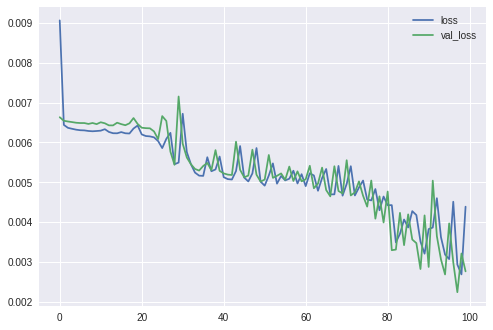

In [154]:
for label in ["loss","val_loss"]:
    plt.plot(histroy.history[label],label=label)
plt.legend()
plt.show()

## Generate testing data

In [145]:
X_test, y_test = generate_data(D=D,T=T,Nsequence = 5000)

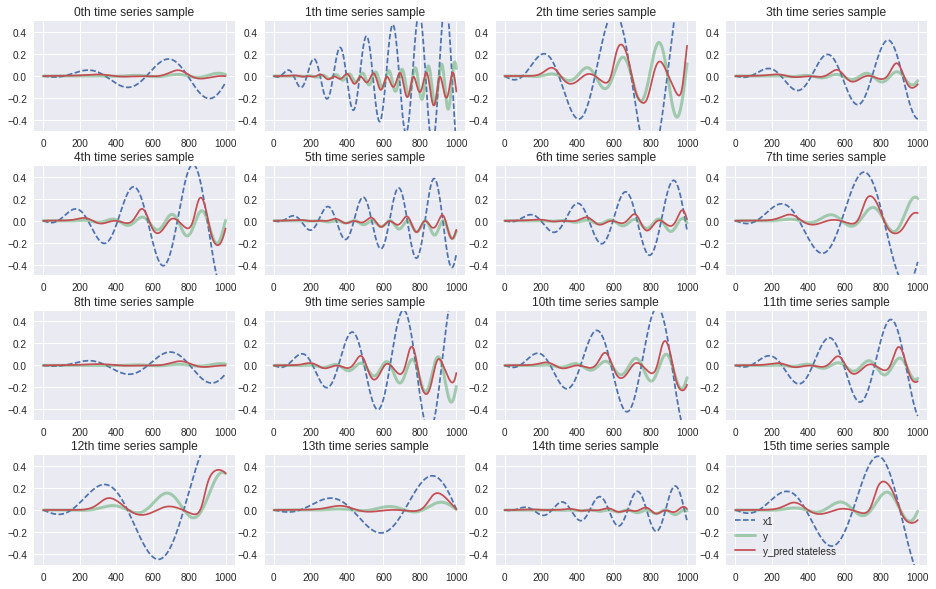

The final validation loss of y_pred stateless is 0.004058


In [161]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

## Stateful Model Training
The stateful model gives flexibility of resetting states so you can pass states from batch to batch. However, as a consequence, stateful model requires some book keeping during the training: a set of original time series needs to be trained in the sequential manner and you need to specify when the batch with new sequence starts. 

For example, consider the scenario:
- batch_size = 250, 
- time_series_length_in_batch = 500.

Then the original 250 time series of length 1,000 sec are divided into two groups: the first 500 sec of all the 250 time series goes to batch 1 and the remaining 500 sec of all the 250 time series goes to the batch 2. Batch 3 will contain the first 500 sec of the next 250 time series and the remaining 500 sec goes to the batch 4. As batch 2 contains the continuation of time series in batch 1, states at the 500th time point from batch 1 needs to be passed to the states in batch 2. On the other hand, batch 3 contains completely new time series so states should not be passed from batch 2 to batch 3. 




-------------------

[batch 1]--> pass states --> [batch 2] --> reset states

[batch 3]--> pass states --> [batch 4] --> reset states 

[batch 5]--> pass states --> [batch 6] --> reset states 

[batch 7]--> pass states --> [batch 8] --> reset states 

--------------------

In this formulation, the random batch creation has some constraint: sub time series in batch 2 cannot be trained with sub time series in batch 1. And batch 1 needs to be trained before batch 3. 


The following class define the methods for training procedure.
(Note that this training script save the weights at every back propagation for the sake of algorithm convergence analysis.)

In [131]:
class statefulModel(object):
    def __init__(self,model,print_val_every = 500):
        '''
        model must be stateful keras model object
        batch_input_shape must be specified
        '''
        bis = model.layers[0].get_config()["batch_input_shape"]
        print("batch_input_shape={}".format(bis))
        self.batch_size = bis[0]
        self.ts         = bis[1]
        self.Nfeat      = bis[2]
        self.model      = model
        self.print_val_every = print_val_every 

    def get_mse(self,true,est,w=None):
        '''
        calculate MSE for weights == 1
        '''
        if w is None:
            w = np.zeros(true.shape)
            w[:] = 1
        ytrue = true[w==1].flatten()
        yest = est[w==1].flatten()
      
        SSE = np.sum((ytrue-yest)**2)
        N = np.sum(w==1)
        MSE = SSE/N
        return MSE, (SSE,N)

    def X_val_shape_adj(self,X,X_val_orig,y_val_orig,w_val_orig):
        '''
        Make the dimension of X_val the same as the dimension of X
        by adding zeros. 
        
        It is assumed that: 
        X_val.shape[i] < X.shape[i]
        i = 0, 1, 2
        '''
        X_val =  np.zeros(X.shape)
        X_val[:X_val_orig.shape[0]] = X_val_orig
        
        myshape = list(y_val_orig.shape)
        myshape[0] = X.shape[0]
        y_val = np.zeros(myshape)
        y_val[:y_val_orig.shape[0]] = y_val_orig
        
        myshape = list(w_val_orig.shape)
        myshape[0] = X.shape[0]
        w_val = np.zeros(myshape)
        w_val[:w_val_orig.shape[0]] = w_val_orig
        
        return X_val,y_val,w_val


    def train1epoch(self,X,y,w,epoch=None):
        '''
        devide the training set of time series into batches. 
        '''
        print "  Training.."
        batch_index = np.arange(X.shape[0])
        ## shuffle to create batch containing different time series
        np.random.shuffle(batch_index)
        count = 1
        for ibatch in range(self.batch_size,
                            X.shape[0]+1,
                            self.batch_size):
        
            print "    Batch {:02d}".format(count)
            pick = batch_index[(ibatch-self.batch_size):ibatch]
            if len(pick) < self.batch_size:
                continue
            X_batch = X[pick]
            y_batch = y[pick]
            w_batch = w[pick]
            self.fit_across_time(X_batch,y_batch,w_batch,epoch,ibatch)
            count += 1
    
    def fit_across_time(self,X,y,w,epoch=None,ibatch=None):
        '''
        training for the given set of time series 
        It always starts at the time point 0 so we need to reset states to zero.
        '''
        self.model.reset_states()
        for itime in range(self.ts,X.shape[1]+1,self.ts):
            ## extract sub time series
            Xtime = X[:,itime-self.ts:itime,:]
            ytime = y[:,itime-self.ts:itime,:]
            wtime = w[:,itime-self.ts:itime]
            if np.all(wtime == 0):
                continue
            val = self.model.fit(Xtime,ytime,
                        nb_epoch=1,
                        ## no shuffling across rows (i.e. time series)
                        shuffle=False,
                        ## use all the samples in one epoch
                        batch_size=X.shape[0],
                        sample_weight=wtime,
                        verbose=False)
            if itime % self.print_val_every == 0:
                print "      {start:4d}:{end:4d} loss={val:.3f}".format(
                start=itime-self.ts, end=itime, val=val.history["loss"][0])
                sys.stdout.flush()
                ## uncomment below if you do not want to save weights for every epoch every batch and every time
                if epoch is not None:
                    self.model.save_weights(
                        "weights_epoch{:03d}_batch{:01d}_time{:04d}.hdf5".format(epoch,ibatch,itime))

 

    def validate1epoch(self,X_val_adj,y_val_adj,w_val_adj):
        batch_index = np.arange(X_val_adj.shape[0])
        print " Validating.."
        val_loss = 0
        count = 1
        for ibatch in range(self.batch_size,
                            X_val_adj.shape[0]+1,
                            self.batch_size):
  
            
            pick = batch_index[(ibatch-self.batch_size):ibatch]
            if len(pick) < self.batch_size:
                continue
            X_val_adj_batch = X_val_adj[pick]
            y_val_adj_batch = y_val_adj[pick]
            w_val_adj_batch = w_val_adj[pick]
            if np.all(w_val_adj_batch==0):
                continue
            print "    Batch {}".format(count)
            SSE,N = self.validate_across_time(
                                     X_val_adj_batch,
                                     y_val_adj_batch,
                                     w_val_adj_batch
                                    )
            val_loss += SSE
            count += N
        val_loss /=count

        return val_loss
    def validate_across_time(self,X_val_adj,y_val_adj,w_val_adj):
        
        y_pred_adj = np.zeros(y_val_adj.shape)
        y_pred_adj[:] = np.NaN
        self.model.reset_states()
        for itime in range(self.ts,
                           X_val_adj.shape[1]+1,
                           self.ts):
            y_pred_adj[:,itime-self.ts:itime,:] = self.model.predict(
                X_val_adj[:,itime-self.ts:itime,:],
                batch_size=X_val_adj.shape[0])
            

            loss,_ = self.get_mse(y_pred_adj[:,itime-self.ts:itime,:],
                                y_val_adj[:,itime-self.ts:itime,:],
                                w_val_adj[:,itime-self.ts:itime])
            if itime % self.print_val_every == 0:
                print "     {start:4d}:{end:4d} val_loss={a:.3f}".format(
                    start=itime-self.ts,end=itime,a=loss)
                sys.stdout.flush()
        
        ## comment out the lines below if you do not want to see the trajectory plots
        fig = plt.figure(figsize=(12,2))
        nplot = 3
        for i in range(nplot):
            ax = fig.add_subplot(1,nplot,i+1)
            ax.plot(y_pred_adj[i,:,0],label="ypred")
            ax.plot(y_val_adj[i,:,0],label="yval")
            ax.set_ylim(-0.5,0.5)
        plt.legend()
        plt.show()
        
        _, (SSE,N) = self.get_mse(y_pred_adj[:,:itime,:],
                                y_val_adj[:,:itime,:],
                                w_val_adj[:,:itime])
        return SSE,N
    def fit(self,
            X,y,w,X_val,y_val,w_val,
            Nepoch=300):
        
        X_val_adj,y_val_adj,w_val_adj = self.X_val_shape_adj(
            X,X_val,y_val,w_val)
        
        past_val_loss = np.Inf
        history = []
        for iepoch in range(Nepoch):
            self.model.reset_states()
            print "__________________________________"
            print "Epoch {}".format(iepoch+1)

            self.train1epoch(X,y,w,iepoch)
    
            val_loss = self.validate1epoch(X_val_adj,
                                           y_val_adj,
                                           w_val_adj)
            print "-----------------> Epoch {iepoch:d} overall valoss={loss:.6f}".format(
            iepoch=iepoch+1,loss=val_loss),
            
            ## uncomments here if you want to save weights only when the weights resulted in lower validation loss
            ##if val_loss < past_val_loss:
            ##    print ">>SAVED<<"
            ##    self.model.save_weights("/model.h5")
            ##    past_val_loss = val_loss
            ##
            print ""
            history.append(val_loss)

        return history

# Define a stateful model
I consider batch size = 400 just as in the stateless model.

In [132]:

model_stateful, _ = define_model(
    hidden_neurons = hunits,
    batch_size=400,
    stateful=True,
    len_ts = 500)

model_stateful.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (400, 500, 1)             0         
_________________________________________________________________
RNN (LSTM)                   (400, 500, 64)            16896     
_________________________________________________________________
time_distributed_16 (TimeDis (400, 500, 1)             65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Training

The log shows the training loss and validation loss for the first 500 sec of time series and the next 500 sec of time series for each batch separately. It is clear that the model performance is lower in the last 500 sec in every epoch. This makes sense because the data shows more variability in that region.
Three example validation time series are also plotted.



batch_input_shape=(400, 500, 1)
__________________________________
Epoch 1
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.015
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


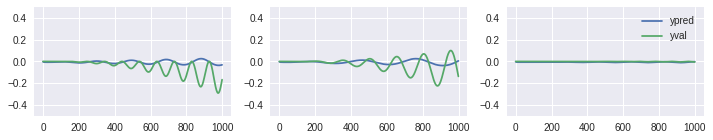

-----------------> Epoch 1 overall valoss=0.007259 
__________________________________
Epoch 2
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


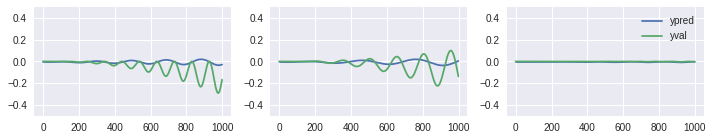

-----------------> Epoch 2 overall valoss=0.007213 
__________________________________
Epoch 3
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


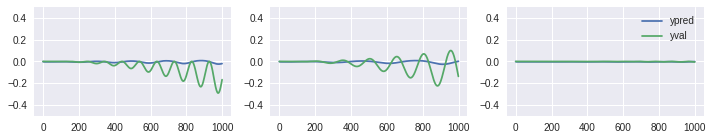

-----------------> Epoch 3 overall valoss=0.007170 
__________________________________
Epoch 4
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


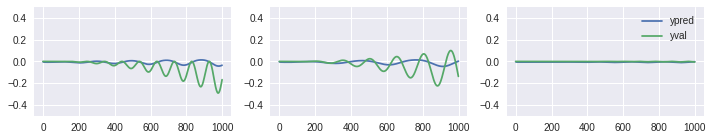

-----------------> Epoch 4 overall valoss=0.007212 
__________________________________
Epoch 5
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


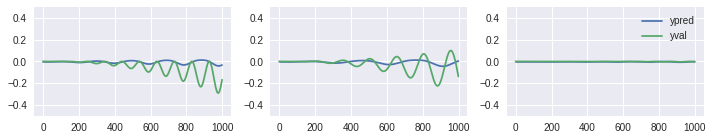

-----------------> Epoch 5 overall valoss=0.007183 
__________________________________
Epoch 6
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


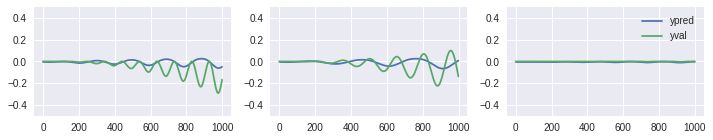

-----------------> Epoch 6 overall valoss=0.007309 
__________________________________
Epoch 7
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


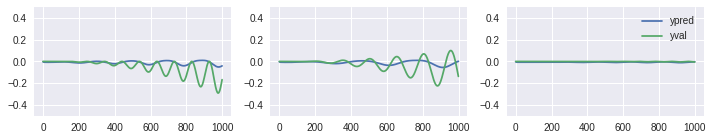

-----------------> Epoch 7 overall valoss=0.007225 
__________________________________
Epoch 8
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


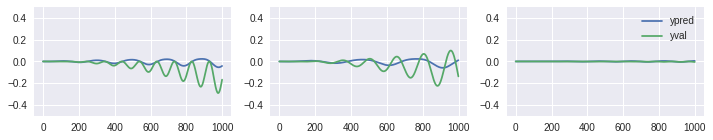

-----------------> Epoch 8 overall valoss=0.007235 
__________________________________
Epoch 9
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


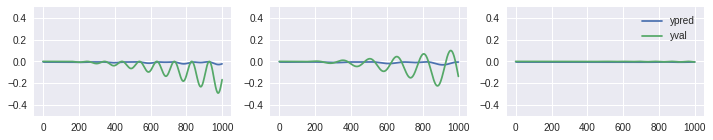

-----------------> Epoch 9 overall valoss=0.007191 
__________________________________
Epoch 10
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


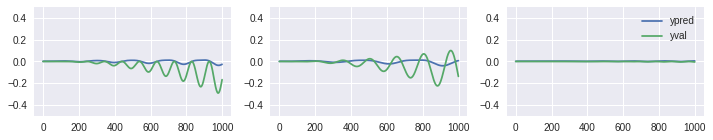

-----------------> Epoch 10 overall valoss=0.007153 
__________________________________
Epoch 11
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


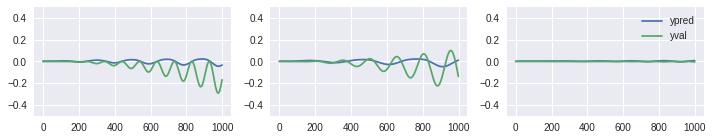

-----------------> Epoch 11 overall valoss=0.007200 
__________________________________
Epoch 12
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


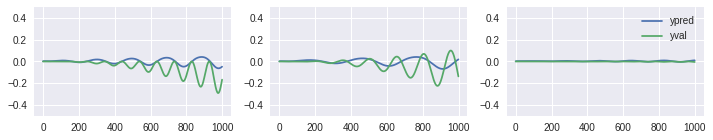

-----------------> Epoch 12 overall valoss=0.007400 
__________________________________
Epoch 13
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


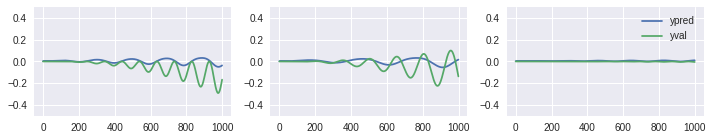

-----------------> Epoch 13 overall valoss=0.007281 
__________________________________
Epoch 14
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


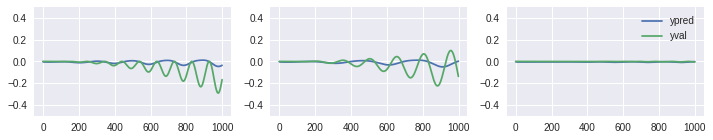

-----------------> Epoch 14 overall valoss=0.007183 
__________________________________
Epoch 15
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


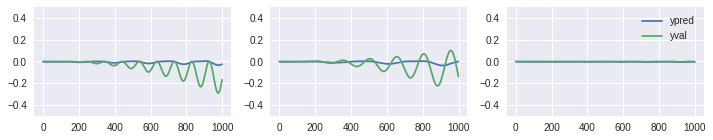

-----------------> Epoch 15 overall valoss=0.007143 
__________________________________
Epoch 16
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


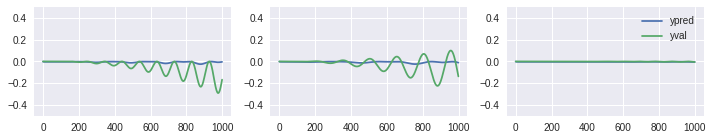

-----------------> Epoch 16 overall valoss=0.007282 
__________________________________
Epoch 17
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


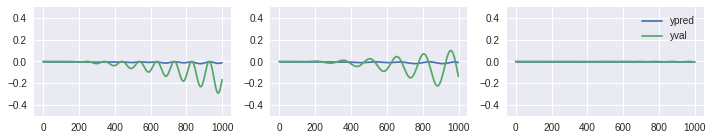

-----------------> Epoch 17 overall valoss=0.007223 
__________________________________
Epoch 18
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


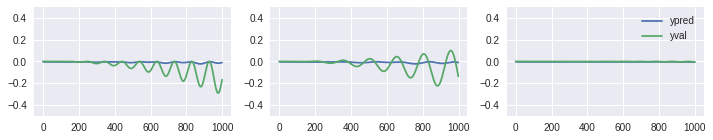

-----------------> Epoch 18 overall valoss=0.007235 
__________________________________
Epoch 19
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


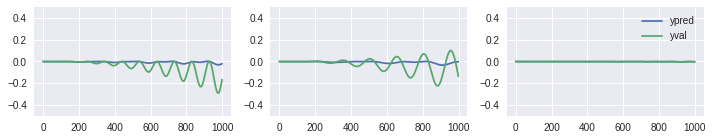

-----------------> Epoch 19 overall valoss=0.007136 
__________________________________
Epoch 20
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


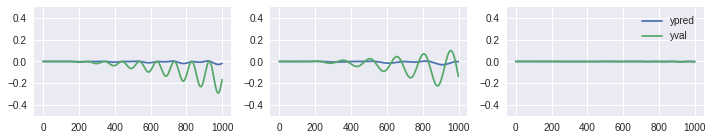

-----------------> Epoch 20 overall valoss=0.007123 
__________________________________
Epoch 21
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


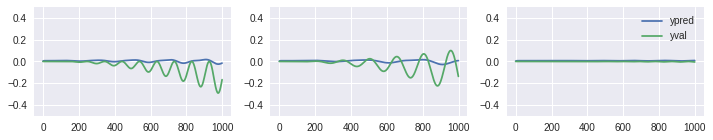

-----------------> Epoch 21 overall valoss=0.007147 
__________________________________
Epoch 22
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


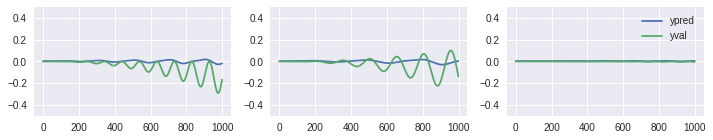

-----------------> Epoch 22 overall valoss=0.007098 
__________________________________
Epoch 23
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


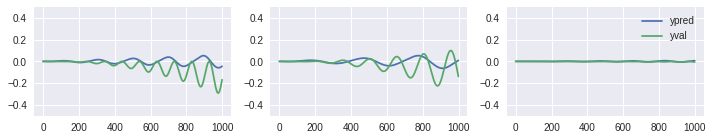

-----------------> Epoch 23 overall valoss=0.007309 
__________________________________
Epoch 24
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


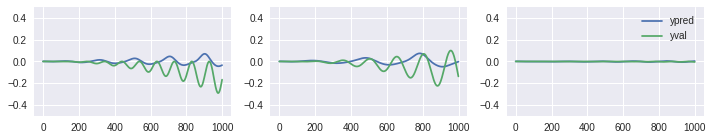

-----------------> Epoch 24 overall valoss=0.007086 
__________________________________
Epoch 25
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.013


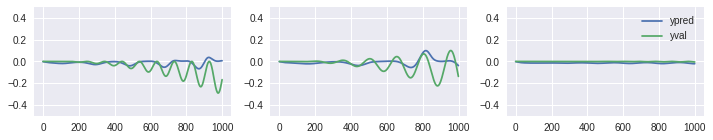

-----------------> Epoch 25 overall valoss=0.007330 
__________________________________
Epoch 26
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.014
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.013


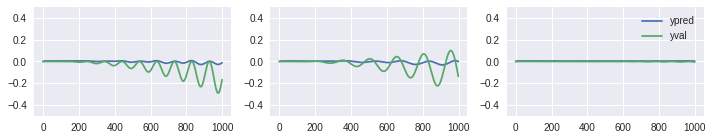

-----------------> Epoch 26 overall valoss=0.007194 
__________________________________
Epoch 27
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


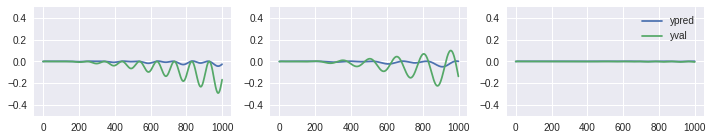

-----------------> Epoch 27 overall valoss=0.007048 
__________________________________
Epoch 28
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


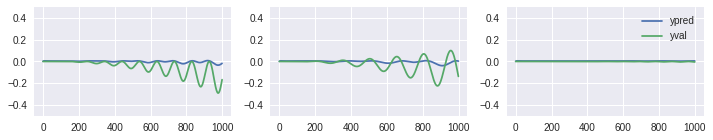

-----------------> Epoch 28 overall valoss=0.006954 
__________________________________
Epoch 29
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.013
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


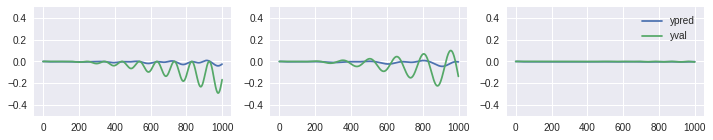

-----------------> Epoch 29 overall valoss=0.006786 
__________________________________
Epoch 30
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.011


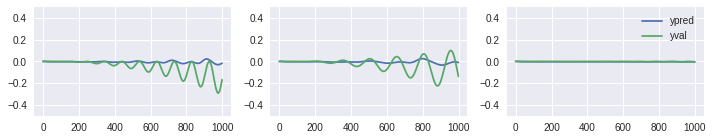

-----------------> Epoch 30 overall valoss=0.006396 
__________________________________
Epoch 31
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


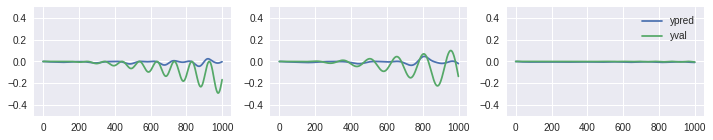

-----------------> Epoch 31 overall valoss=0.005889 
__________________________________
Epoch 32
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.020


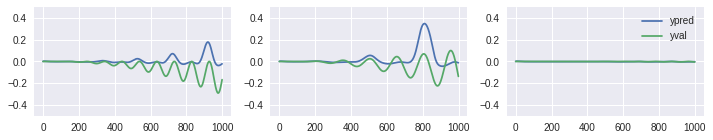

-----------------> Epoch 32 overall valoss=0.011183 
__________________________________
Epoch 33
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.014
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


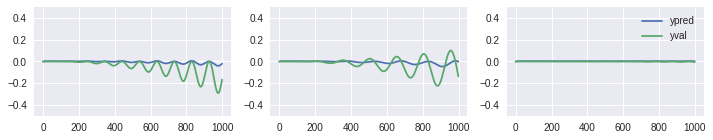

-----------------> Epoch 33 overall valoss=0.006942 
__________________________________
Epoch 34
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.013
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


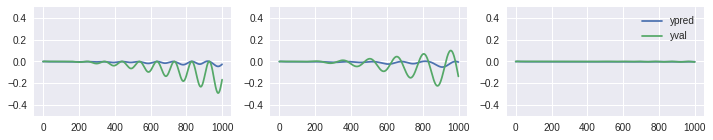

-----------------> Epoch 34 overall valoss=0.006642 
__________________________________
Epoch 35
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.011


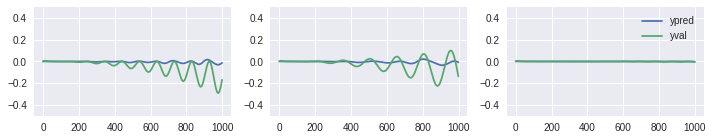

-----------------> Epoch 35 overall valoss=0.006194 
__________________________________
Epoch 36
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


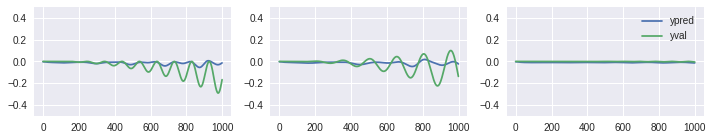

-----------------> Epoch 36 overall valoss=0.005879 
__________________________________
Epoch 37
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.012


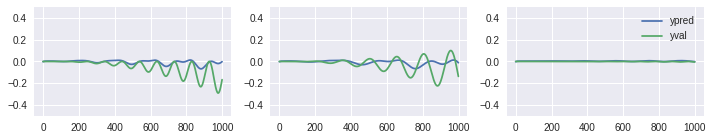

-----------------> Epoch 37 overall valoss=0.006595 
__________________________________
Epoch 38
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.011
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.011


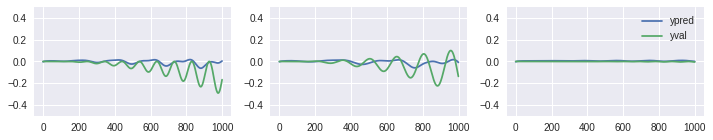

-----------------> Epoch 38 overall valoss=0.006454 
__________________________________
Epoch 39
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


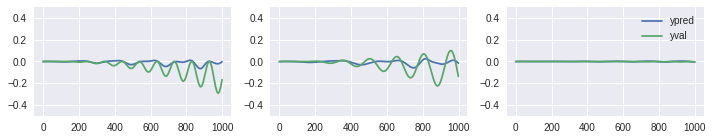

-----------------> Epoch 39 overall valoss=0.005579 
__________________________________
Epoch 40
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


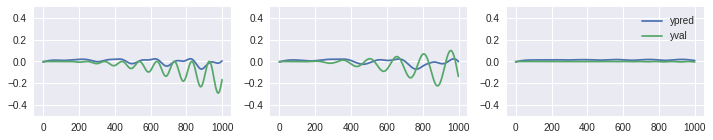

-----------------> Epoch 40 overall valoss=0.006312 
__________________________________
Epoch 41
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.012
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.013


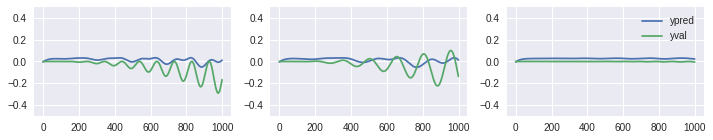

-----------------> Epoch 41 overall valoss=0.007898 
__________________________________
Epoch 42
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.014
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


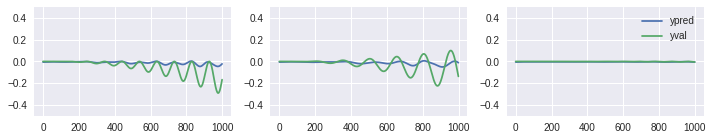

-----------------> Epoch 42 overall valoss=0.005934 
__________________________________
Epoch 43
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


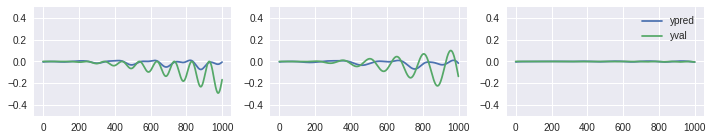

-----------------> Epoch 43 overall valoss=0.005574 
__________________________________
Epoch 44
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


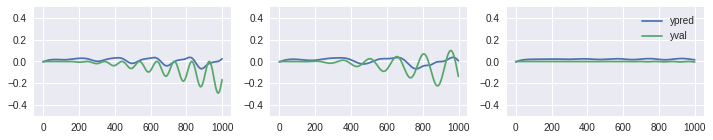

-----------------> Epoch 44 overall valoss=0.006649 
__________________________________
Epoch 45
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.010


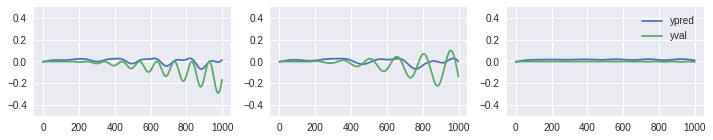

-----------------> Epoch 45 overall valoss=0.006031 
__________________________________
Epoch 46
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


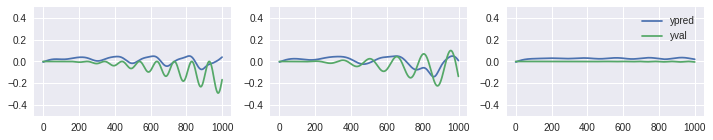

-----------------> Epoch 46 overall valoss=0.006568 
__________________________________
Epoch 47
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


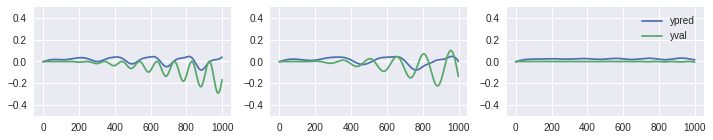

-----------------> Epoch 47 overall valoss=0.006723 
__________________________________
Epoch 48
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


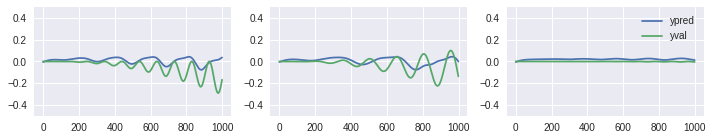

-----------------> Epoch 48 overall valoss=0.006586 
__________________________________
Epoch 49
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


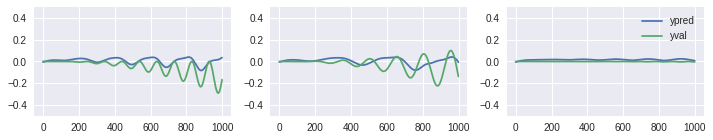

-----------------> Epoch 49 overall valoss=0.006294 
__________________________________
Epoch 50
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


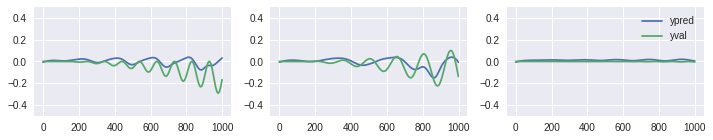

-----------------> Epoch 50 overall valoss=0.006118 
__________________________________
Epoch 51
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.011


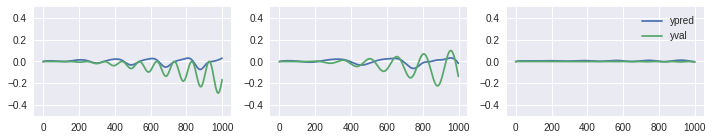

-----------------> Epoch 51 overall valoss=0.006206 
__________________________________
Epoch 52
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.008


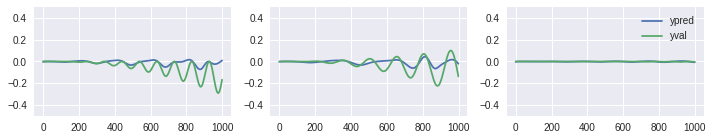

-----------------> Epoch 52 overall valoss=0.004871 
__________________________________
Epoch 53
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


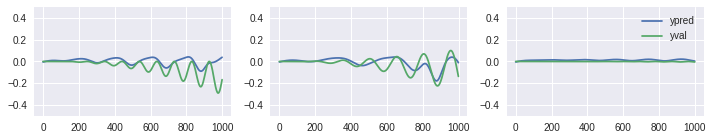

-----------------> Epoch 53 overall valoss=0.005124 
__________________________________
Epoch 54
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


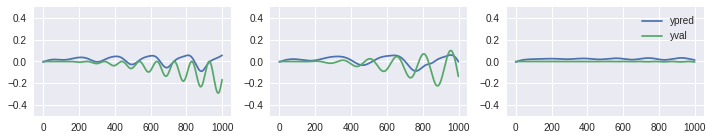

-----------------> Epoch 54 overall valoss=0.006700 
__________________________________
Epoch 55
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


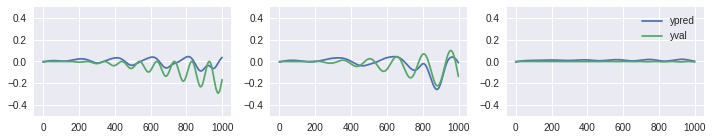

-----------------> Epoch 55 overall valoss=0.005238 
__________________________________
Epoch 56
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


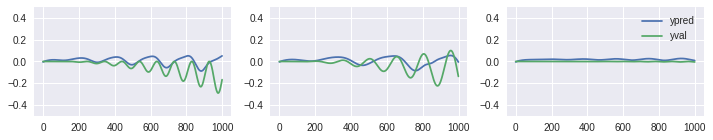

-----------------> Epoch 56 overall valoss=0.006500 
__________________________________
Epoch 57
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.008


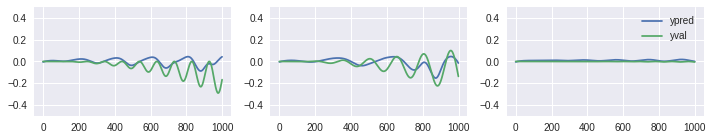

-----------------> Epoch 57 overall valoss=0.004975 
__________________________________
Epoch 58
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.016
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.012


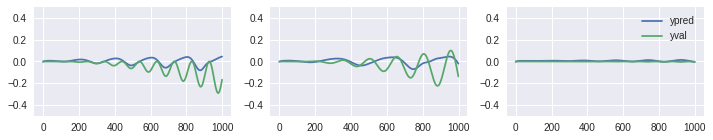

-----------------> Epoch 58 overall valoss=0.006789 
__________________________________
Epoch 59
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.012
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


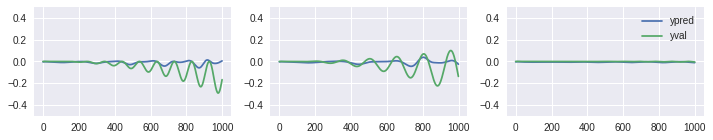

-----------------> Epoch 59 overall valoss=0.005800 
__________________________________
Epoch 60
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


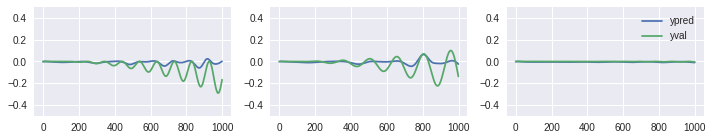

-----------------> Epoch 60 overall valoss=0.005546 
__________________________________
Epoch 61
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.009


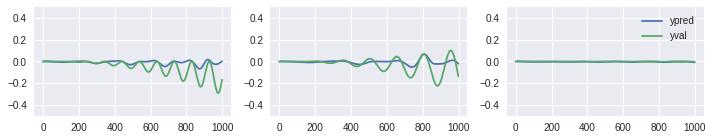

-----------------> Epoch 61 overall valoss=0.005259 
__________________________________
Epoch 62
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.009


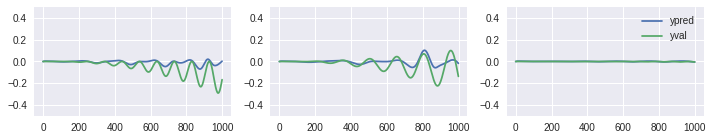

-----------------> Epoch 62 overall valoss=0.005019 
__________________________________
Epoch 63
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


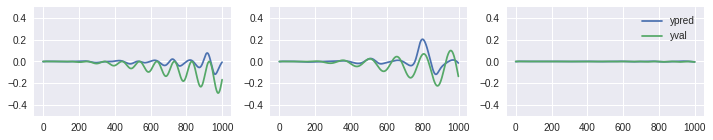

-----------------> Epoch 63 overall valoss=0.005753 
__________________________________
Epoch 64
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.008


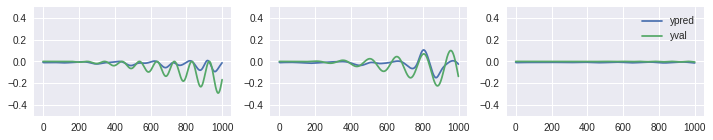

-----------------> Epoch 64 overall valoss=0.004636 
__________________________________
Epoch 65
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.008


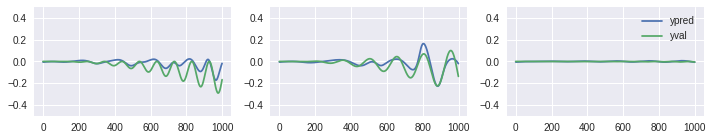

-----------------> Epoch 65 overall valoss=0.004421 
__________________________________
Epoch 66
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


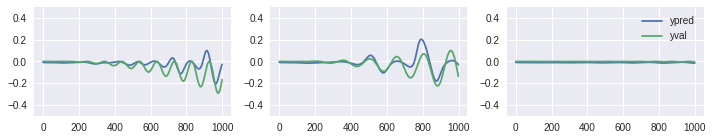

-----------------> Epoch 66 overall valoss=0.005629 
__________________________________
Epoch 67
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.008


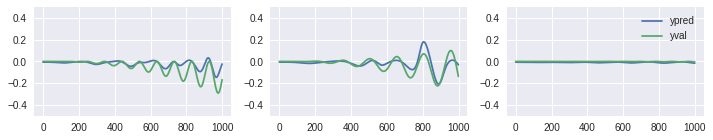

-----------------> Epoch 67 overall valoss=0.004751 
__________________________________
Epoch 68
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


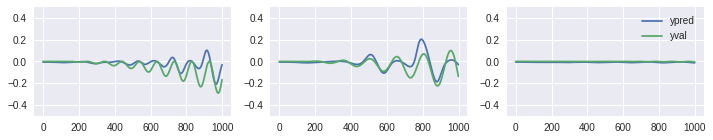

-----------------> Epoch 68 overall valoss=0.005471 
__________________________________
Epoch 69
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


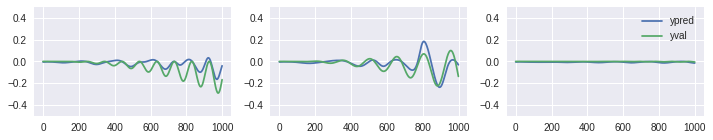

-----------------> Epoch 69 overall valoss=0.004975 
__________________________________
Epoch 70
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.008


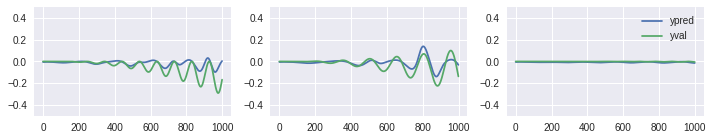

-----------------> Epoch 70 overall valoss=0.004494 
__________________________________
Epoch 71
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


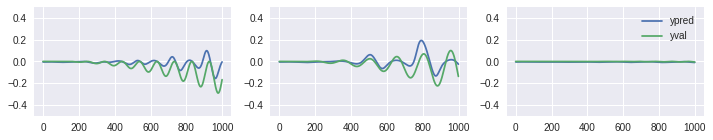

-----------------> Epoch 71 overall valoss=0.005566 
__________________________________
Epoch 72
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.008


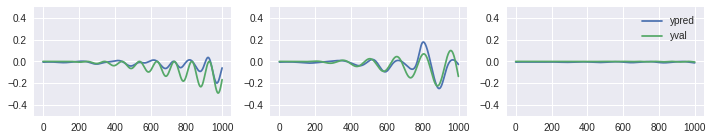

-----------------> Epoch 72 overall valoss=0.004722 
__________________________________
Epoch 73
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


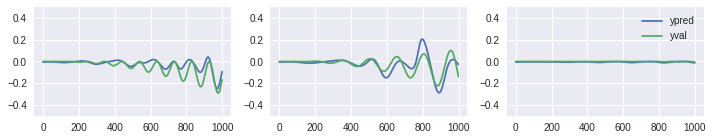

-----------------> Epoch 73 overall valoss=0.005049 
__________________________________
Epoch 74
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.009


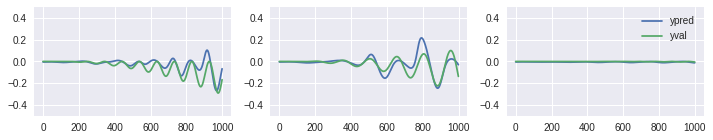

-----------------> Epoch 74 overall valoss=0.005097 
__________________________________
Epoch 75
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.010


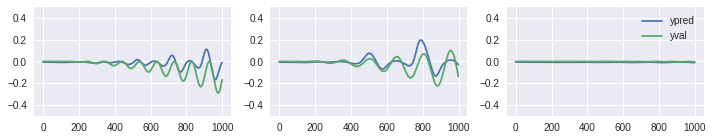

-----------------> Epoch 75 overall valoss=0.005747 
__________________________________
Epoch 76
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


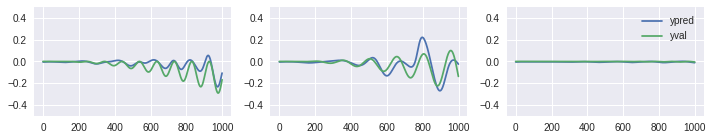

-----------------> Epoch 76 overall valoss=0.005440 
__________________________________
Epoch 77
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.018


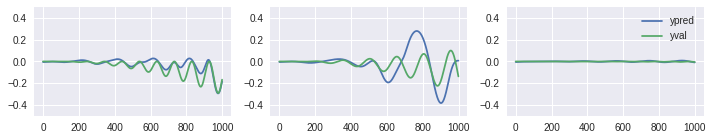

-----------------> Epoch 77 overall valoss=0.010407 
__________________________________
Epoch 78
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.011
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.009


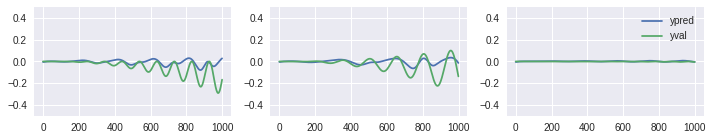

-----------------> Epoch 78 overall valoss=0.005452 
__________________________________
Epoch 79
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.010
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


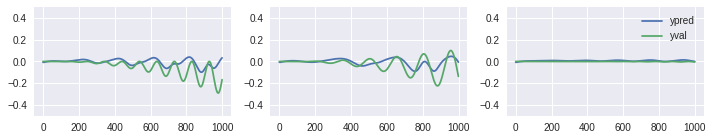

-----------------> Epoch 79 overall valoss=0.005298 
__________________________________
Epoch 80
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


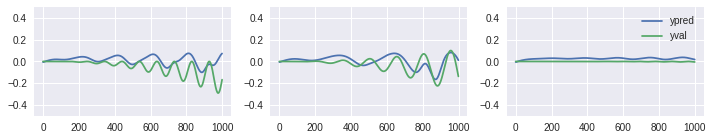

-----------------> Epoch 80 overall valoss=0.005597 
__________________________________
Epoch 81
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


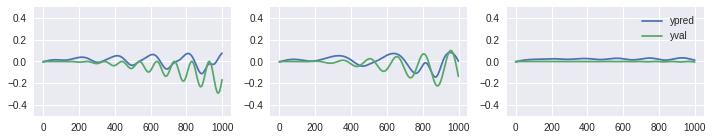

-----------------> Epoch 81 overall valoss=0.005489 
__________________________________
Epoch 82
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.008


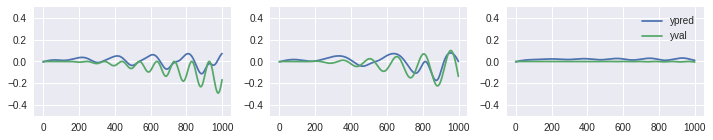

-----------------> Epoch 82 overall valoss=0.005087 
__________________________________
Epoch 83
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.007
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.009


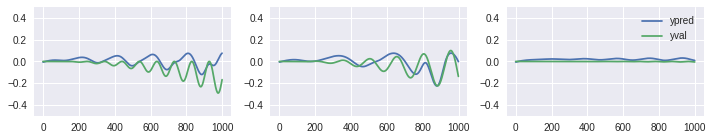

-----------------> Epoch 83 overall valoss=0.005339 
__________________________________
Epoch 84
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.008


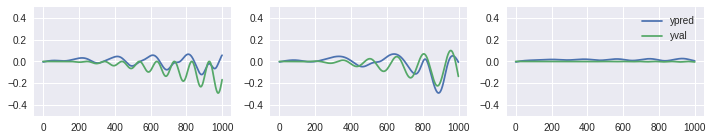

-----------------> Epoch 84 overall valoss=0.004870 
__________________________________
Epoch 85
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.008


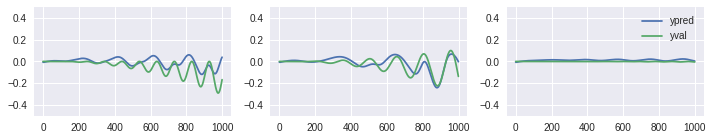

-----------------> Epoch 85 overall valoss=0.004850 
__________________________________
Epoch 86
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.007
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.007


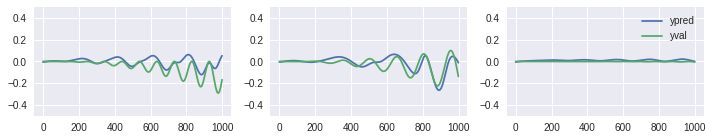

-----------------> Epoch 86 overall valoss=0.004247 
__________________________________
Epoch 87
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.006
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.007


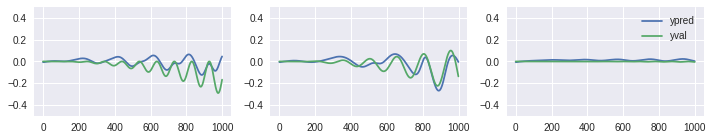

-----------------> Epoch 87 overall valoss=0.004450 
__________________________________
Epoch 88
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.006
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.009
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.008


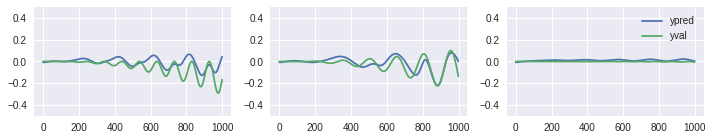

-----------------> Epoch 88 overall valoss=0.004752 
__________________________________
Epoch 89
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.006


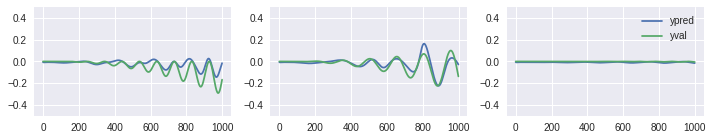

-----------------> Epoch 89 overall valoss=0.003650 
__________________________________
Epoch 90
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.006
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.006


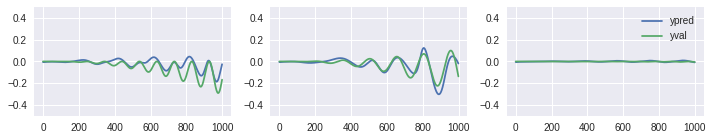

-----------------> Epoch 90 overall valoss=0.003619 
__________________________________
Epoch 91
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.006
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.011


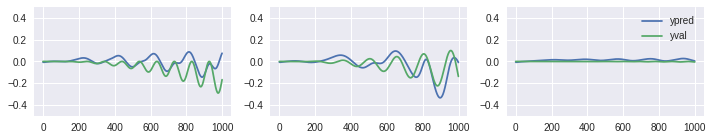

-----------------> Epoch 91 overall valoss=0.006676 
__________________________________
Epoch 92
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.010
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.009


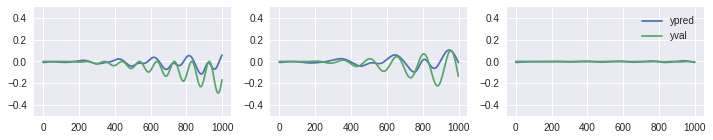

-----------------> Epoch 92 overall valoss=0.005037 
__________________________________
Epoch 93
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.006


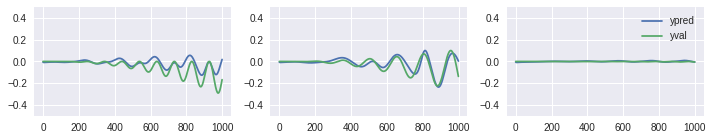

-----------------> Epoch 93 overall valoss=0.003392 
__________________________________
Epoch 94
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.006
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.008


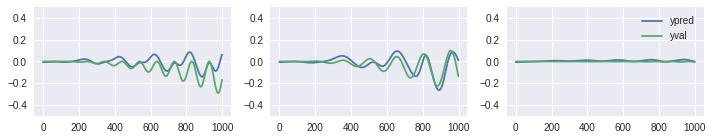

-----------------> Epoch 94 overall valoss=0.004478 
__________________________________
Epoch 95
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.006
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.012


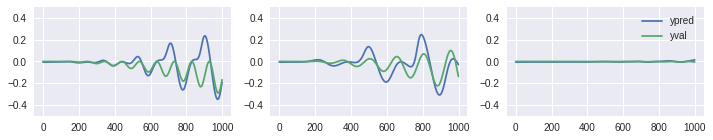

-----------------> Epoch 95 overall valoss=0.007137 
__________________________________
Epoch 96
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.009
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.007
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.014


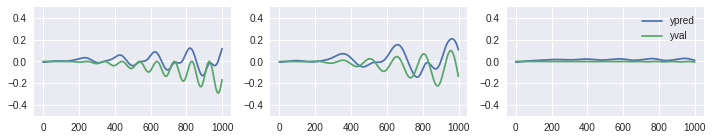

-----------------> Epoch 96 overall valoss=0.008292 
__________________________________
Epoch 97
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.008
 Validating..
    Batch 1
        0: 500 val_loss=0.001
      500:1000 val_loss=0.010


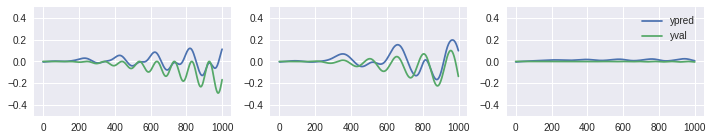

-----------------> Epoch 97 overall valoss=0.005924 
__________________________________
Epoch 98
  Training..
    Batch 01
         0: 500 loss=0.001
       500:1000 loss=0.007
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.005
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.006


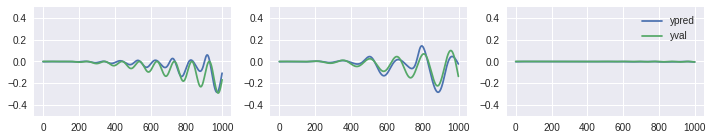

-----------------> Epoch 98 overall valoss=0.003494 
__________________________________
Epoch 99
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.006
    Batch 02
         0: 500 loss=0.001
       500:1000 loss=0.007
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.009


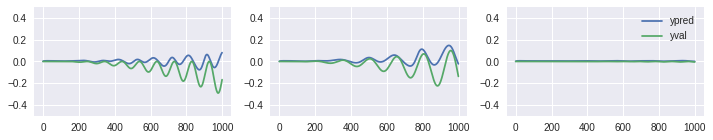

-----------------> Epoch 99 overall valoss=0.004981 
__________________________________
Epoch 100
  Training..
    Batch 01
         0: 500 loss=0.000
       500:1000 loss=0.008
    Batch 02
         0: 500 loss=0.000
       500:1000 loss=0.007
 Validating..
    Batch 1
        0: 500 val_loss=0.000
      500:1000 val_loss=0.006


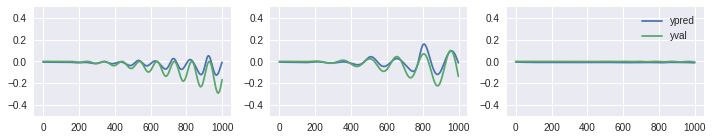

-----------------> Epoch 100 overall valoss=0.003355 
Time Took 7.10 min


In [133]:
smodel = statefulModel(model=model_stateful,print_val_every=500)

start = time.time()
history_stateful = smodel.fit(X_train,y_train,w_train,
                               X_val,y_val,w_val,
                               Nepoch=100)
    
end = time.time()
print("Time Took {:3.2f} min".format((end - start)/60))

## The validation loss plot, stateful and stateless models
**The validation loss plot shows that the back propagation algorithm of the stateless model seems less stable.**

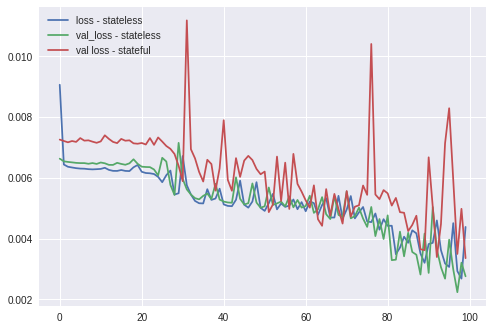

In [178]:
for label in ["loss","val_loss"]:
    plt.plot(histroy.history[label],label=label + " - stateless")
plt.plot(history_stateful,label="val loss - stateful")

plt.legend()

plt.show()

## Prediction phase
For model testing, I want to predict $Y_t$ at every time point, one at a time. 
Therefore, I re-define a model with batch_size = (1000,1,2).

As I am concerned about the unstable behavior of the back propagation algorithm in the stateful training, 
I will provide the last 4 training weights obtained during the final epoch. 


In [174]:
model_pred1,_ = define_model(len_ts=1,
                            hidden_neurons = hunits,
                            batch_size=X_test.shape[0],
                            stateful=True)
model_pred2, _ = define_model(len_ts=1,
                            hidden_neurons = hunits,
                            batch_size=X_test.shape[0],
                            stateful=True)
model_pred3, _ = define_model(len_ts=1,
                            hidden_neurons = hunits,
                            batch_size=X_test.shape[0],
                            stateful=True)
model_pred4, _ = define_model(len_ts=1,
                            hidden_neurons = hunits,
                            batch_size=X_test.shape[0],
                            stateful=True)

## load the final weights
model_pred1.load_weights("weights_epoch099_batch800_time1000.hdf5")
model_pred2.load_weights("weights_epoch099_batch800_time0500.hdf5")
model_pred3.load_weights("weights_epoch099_batch400_time1000.hdf5")
model_pred4.load_weights("weights_epoch099_batch400_time0500.hdf5")
model_pred1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (5000, 1, 1)              0         
_________________________________________________________________
RNN (LSTM)                   (5000, 1, 64)             16896     
_________________________________________________________________
time_distributed_25 (TimeDis (5000, 1, 1)              65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


Define the prediction function for the stateful model.

In [175]:
def stateful_prediction(mm,X_test,ntarget=1):
        #expecting..
        bis = mm.layers[0].get_config()["batch_input_shape"]
        batch_size, ts, nfeat = bis
        assert(X_test.shape[0] % batch_size == 0)
        assert(X_test.shape[1] % ts == 0) 

        y_pred = np.zeros((X_test.shape[0],
                           X_test.shape[1],
                           ntarget))
        y_pred[:] = np.NaN
        for ipat in range(0,X_test.shape[0],batch_size):
            mm.reset_states()
            for itime in range(0,X_test.shape[1],ts):
                X_testi = X_test[ipat:(ipat+batch_size),
                                  itime:(itime+ts),:]
                y_pred[ipat:(ipat+batch_size),
                       itime:(itime+ts),:] = mm.predict(
                    X_testi,
                    batch_size=batch_size)
        return y_pred

Prediction

In [176]:
y_pred_stateful1 = stateful_prediction(mm=model_pred1,X_test=X_test)
y_pred_stateful2 = stateful_prediction(mm=model_pred2,X_test=X_test)
y_pred_stateful3 = stateful_prediction(mm=model_pred3,X_test=X_test)
y_pred_stateful4 = stateful_prediction(mm=model_pred4,X_test=X_test)

# Evaluate the model performance on testing data 
The stateful model outperform stateless twice, and perform much worse once.


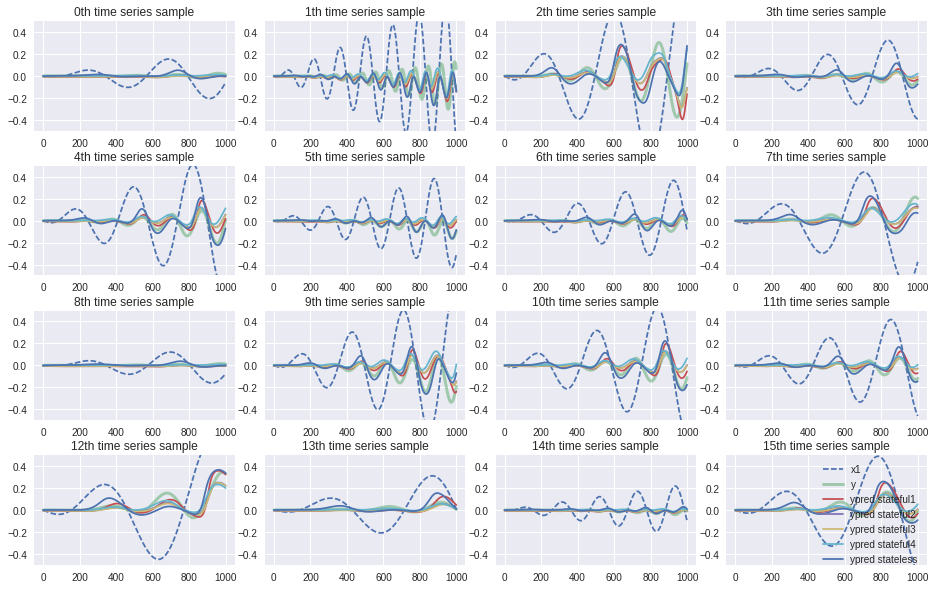

The final validation loss of ypred stateful1 is 0.003775
The final validation loss of ypred stateful2 is 0.004036
The final validation loss of ypred stateful3 is 0.004058
The final validation loss of ypred stateful4 is 0.004992
The final validation loss of ypred stateless is 0.004058


In [177]:
plot_examples(X_test,y_test,
              ypreds=[y_pred_stateful1,y_pred_stateful2,y_pred_stateful3,y_pred_stateful4,
                      y_pred_stateless],
              nm_ypreds=["ypred stateful1","ypred stateful2","ypred stateful3","ypred stateful4",
                         "ypred stateless"])

# Let's see how the weights are changing over epochs.

In [139]:
def get_LSTM_UWb(weight):
    '''
    weight must be output of LSTM's layer.get_weights()
    W: weights for input
    U: weights for hidden states
    b: bias
    '''
    warr,uarr, barr = weight
    gates = ["i","f","c","o"]
    hunit = uarr.shape[0]
    U, W, b = {},{},{}
    for i1,i2 in enumerate(range(0,len(barr),hunit)):
        
        W[gates[i1]] = warr[:,i2:i2+hunit]
        U[gates[i1]] = uarr[:,i2:i2+hunit]
        b[gates[i1]] = barr[i2:i2+hunit].reshape(hunit,1)
    return(W,U,b)

def get_LSTMweights(model1):
    for layer in model1.layers:
        if "LSTM" in str(layer):
            w = layer.get_weights()
            W,U,b = get_LSTM_UWb(w)
            break
    return W,U,b
def vectorize_with_labels(W,U,b):
    bs,bs_label,ws,ws_label,us,us_label=[],[],[],[],[],[]
    for k in ["i","f","c","o"]:
        temp = list(W[k].flatten())
        ws_label.extend(["W_"+k]*len(temp))
        ws.extend(temp)

        temp = list(U[k].flatten())
        us_label.extend(["U_"+k]*len(temp))
        us.extend(temp)    

        temp = list(b[k].flatten())
        bs_label.extend(["b_"+k]*len(temp))
        bs.extend(temp)  
    weight = ws + us + bs
    wlabel = ws_label + us_label + bs_label
    return(weight,wlabel)

In [210]:
from copy import copy
import pandas as pd 
df = {}
ibatch = 800
for epoch in np.arange(50,100,1):
    for itime in [500,1000]:
        title = "weights_epoch{:03d}_batch{:01d}_time{:04d}.hdf5".format(epoch,ibatch,itime)
        model_stateful.load_weights(title)
        WUb = get_LSTMweights(model_stateful)
        weight,wlabel = vectorize_with_labels(*WUb)
        df["epoch{:03d} time{:04d}".format(epoch,itime)] = copy(weight)
        
df = pd.DataFrame(df,
                  index=[ lab + "_" +  str(i) for i, lab in enumerate(wlabel)])
dfT =df.T

## Plot the weight change over every back propagation


### Observation and conclusions:
- Stateful procedure seems to be working in the sense that it returns comparable results as stateless procedure.

- The bias for cell states, forget gate, input gate and output gate seem to be oscillating between the back propagation of the batch with the first 500 sec and the next 500 sec. 

- This observation again confirms the the unstable convergence of back propagation algorithm.

- Stateful training does not allow shuffling between the sub time series of the first 500 sec and the next 500 sec. 

- This may be causing the back propagation algorithm unstable. 

- Unless a single time series is too large to fit in to a single batch, I do not recommend to use the stateful training method as stateless model outperforms the stateful model.



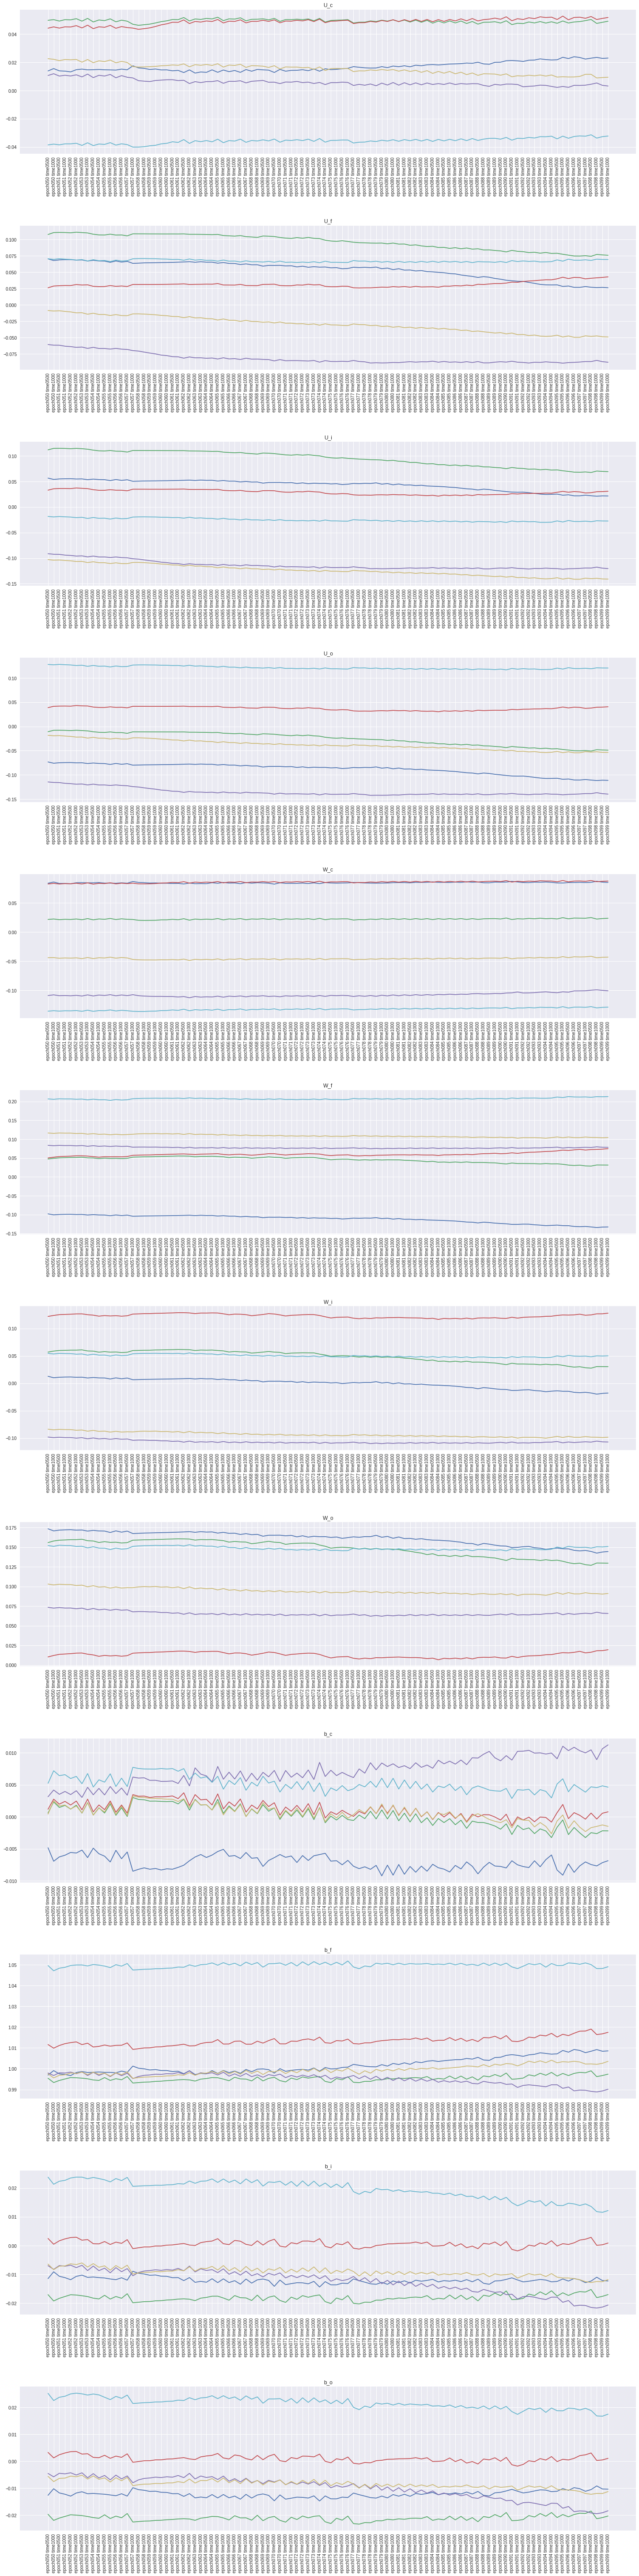

In [211]:
unilabel = np.unique(wlabel)
fig = plt.figure(figsize=(25,105))
fig.subplots_adjust(hspace=0.5,wspace=0.01)
count = 1 
for weight_type in unilabel:
    ax = fig.add_subplot(12,1,count)
    nweight = 0
    for colnm in dfT.columns:
        if weight_type in colnm:
            ax.plot(dfT[colnm].values,label=weight_type + "_" +  str(count))
            ax.set_title(weight_type)
            ax.set_xticks( range(dfT.shape[0]) )
            ax.set_xticklabels(list(dfT.index.values),rotation="vertical")
            nweight+=1
            if nweight > 5:
                break
    count += 1
plt.show()